# Telco Churn in Sagemaker - 1 model (XGBoost) with 5 Hyperparams

In [1]:
bucket='telco-churn-cp' # <--- Change this to actual bucket name

## Section 1: Setup of Environment

### Step 1A: Importing Libraries

In [2]:
import time
start = time.time()
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
from scipy.io import arff
import io

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.estimator import Estimator

[03/31/25 22:45:40] INFO     Found credentials from IAM Role:                                   ]8;id=520230;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=940520;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[03/31/25 22:46:05] WARNING  Matplotlib is building the font cache; this may take a moment.    ]8;id=212517;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=889114;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

[03/31/25 22:46:07] INFO     generated new fontManager                                         ]8;id=318498;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=703548;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

### Step 1B: Define Functions for ROC curve/Confusion Matrix

In [3]:
# Step 1B: Define functions for ROC curve and confusion matrix
# plot_roc function to plot ROC curve and calculate metrics
def plot_roc(test_labels, target_predicted_binary):
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 

    print("Validation AUC", roc_auc_score(test_labels, target_predicted_binary) )

    fpr, tpr, thresholds = roc_curve(test_labels, target_predicted_binary)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # Filter out non-finite values before setting limits
    valid_indices = np.isfinite(thresholds)
    if any(valid_indices):
        filtered_fpr = fpr[valid_indices]
        filtered_thresholds = thresholds[valid_indices]
        if len(filtered_thresholds) > 1:
            # create the axis of thresholds (scores)
            ax2 = plt.gca().twinx()
            ax2.plot(filtered_fpr, filtered_thresholds, markeredgecolor='r', linestyle='dashed', color='r')
            ax2.set_ylabel('Threshold', color='r')
            ax2.set_ylim([min(filtered_thresholds), max(filtered_thresholds)])
            ax2.set_xlim([min(filtered_fpr), max(filtered_fpr)])
    
    plt.show()

def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()

### Step 1C: Load the data

In [4]:
# Define S3 bucket and object key
s3_bucket = bucket  # References existing bucket variable from your template
s3_key = 'df_for_sm.csv'  # Path to your data file in the bucket root

# Create S3 client and download the file
s3 = boto3.client('s3')  # Initialize S3 client with AWS credentials
obj = s3.get_object(Bucket=s3_bucket, Key=s3_key)  # Retrieve the S3 object
data = obj['Body'].read()  # Read file content as bytes

# Load data into a DataFrame
df = pd.read_csv(io.BytesIO(data))  # Convert bytes to file-like object and read as CSV
df.head()

[03/31/25 22:46:10] INFO     Found credentials from IAM Role:                                   ]8;id=827576;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=696933;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

,Churn,ohe__Gender_Female,ohe__Gender_Male,contract_ord__Contract,internet_ord__Internet Type,service_ord__Service_Level,scaler__Age,scaler__Avg Monthly GB Download,scaler__Avg Monthly Long Distance Charges,scaler__Number of Dependents,...,remainder__Paperless Billing,remainder__Partner,remainder__Phone Service,remainder__Premium Tech Support,remainder__Streaming Movies,remainder__Streaming Music,remainder__Streaming TV,remainder__Unlimited Data,remainder__Refunds Awarded,remainder__Phone_Bundle
0,0,1.0,0.0,0.289021,-0.628053,0.302288,-0.448364,0.415555,-0.262119,2.629292,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0,0.0,1.0,-0.889657,1.018161,1.487710,1.700997,0.072712,0.681105,-0.486835,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
2,0,1.0,0.0,1.467699,1.018161,1.487710,1.223361,-0.319109,-0.841519,-0.486835,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,0,0.0,1.0,-0.889657,-0.628053,0.302288,0.029272,-0.661952,0.756201,-0.486835,...,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0,1.0,0.0,0.289021,-1.451160,-0.883133,-1.523045,-1.004796,-0.807208,-0.486835,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 2: Folder name in S3 bucket

In [6]:
prefix='folders' # <-- Change this to actual prefix name

## Step 3: Defining the S3 bucket and prefix

In [9]:
train, test_and_validate = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Churn'])
test, validate = train_test_split(test_and_validate, test_size=0.5, random_state=42, stratify=test_and_validate['Churn'])

train_file='telco_train.csv'
test_file='telco_test.csv'
validate_file='telco_validate.csv'

## Step 4: Uploading the data to S3 bucket

In [10]:
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

[03/31/25 23:03:40] INFO     Found credentials from IAM Role:                                   ]8;id=828557;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=518086;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [11]:
upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

## Step 5: Define function for batch processing with real-time endpoint

Next round: change to 704

In [12]:
def predict_and_store_in_s3(test_df, predictor, bucket, prefix, batch_size=5, exclude_cols=None):
    """
    Process predictions in batches and store results in S3
    """
    # Create S3 client
    s3 = boto3.client('s3')
    
    # Create copy and remove excluded columns
    df_copy = test_df.copy()
    if exclude_cols:
        df_copy = df_copy.drop(columns=exclude_cols)
    
    # Store all predictions
    all_predictions = []
    
    # Process in batches
    for i in range(0, len(df_copy), batch_size):
        batch = df_copy.iloc[i:min(i+batch_size, len(df_copy))]
        
        # Process each row in the batch
        for _, row_data in batch.iterrows():
            # Convert single row to DataFrame and then to CSV
            row_df = pd.DataFrame([row_data])
            csv_buffer = io.StringIO()
            row_df.to_csv(csv_buffer, header=False, index=False)
            row_csv = csv_buffer.getvalue()
            
            # Get prediction
            try:
                prediction = predictor.predict(row_csv)
                # Extract the prediction value
                pred_value = float(prediction)
                all_predictions.append(pred_value)
            except Exception as e:
                print(f"Error processing row: {e}")
                all_predictions.append(np.nan)
        
        # Optional: Add delay to avoid throttling
        time.sleep(0.1)
    
    # Validate predictions
    if all(np.isnan(all_predictions)):
        print("Warning: All predictions failed, check endpoint functionality")
    
    # Create output file
    output_csv = '\n'.join([str(p) for p in all_predictions])
    
    # Upload to S3
    output_key = f"{prefix}/batch-out/batch-in.csv.out" # will change to batch-in.csv next run
    try:
        s3.put_object(
            Body=output_csv, 
            Bucket=bucket,
            Key=output_key
        )
        print(f"Predictions saved to s3://{bucket}/{output_key}")
    except Exception as e:
        print(f"Error uploading predictions to S3: {e}")
        # Save predictions locally as fallback
        with open('predictions.csv', 'w') as f:
            f.write(output_csv)
        print("Predictions saved locally to predictions.csv")
        
    return output_key

## Step 6: Define binary conversion function

#### CHANGE THRESHOLD ONCE OBTAINED BEST THRESHOLD**!

In [13]:
## Step 6: Define binary conversion function
def binary_convert(x):
    threshold = 0.5 # to change once we have the best threshold offline
    if x > threshold:
        return 1
    else:
        return 0

## Step 7: Verify instance type quota

In [14]:
## Step 7: Verify instance type quota
def check_instance_quota(instance_type):
    try:
        client = boto3.client('service-quotas')
        sm_client = boto3.client('sagemaker')
        
        # Check if there are any existing instances of this type
        endpoints = sm_client.list_endpoints()
        existing_count = 0
        for endpoint in endpoints['Endpoints']:
            endpoint_desc = sm_client.describe_endpoint(EndpointName=endpoint['EndpointName'])
            if instance_type in str(endpoint_desc):
                existing_count += 1
        
        if existing_count > 0:
            print(f"Warning: You have {existing_count} existing endpoints using {instance_type}")
            print("This may affect your ability to create new endpoints with this instance type")
        
        print(f"Proceeding with instance type: {instance_type}")
        return True
    except Exception as e:
        print(f"Could not verify quota for {instance_type}: {e}")
        print("Proceeding anyway, but deployment may fail if quota is exceeded")
        return True

## Step 8: Enhanced Performance Evaluation Functions

In [15]:
## Step 8: Enhanced Performance Evaluation Functions
def calculate_f1_score(y_true, y_pred):
    """Calculate F1 score, which is the harmonic mean of precision and recall"""
    from sklearn.metrics import f1_score
    return f1_score(y_true, y_pred)

def plot_precision_recall_curve(y_true, y_pred_proba):
    """Plot precision-recall curve"""
    from sklearn.metrics import precision_recall_curve, average_precision_score
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    ap = average_precision_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, marker='.', label=f'AP={ap:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return precision, recall, thresholds

In [16]:
def plot_lift_gain_chart(y_true, y_pred_proba):
    """Plot lift and gain charts for model evaluation"""
    # Sort by probability
    df = pd.DataFrame({'true': y_true, 'prob': y_pred_proba})
    df = df.sort_values(by='prob', ascending=False).reset_index(drop=True)
    df['rank'] = df.index + 1
    df['percent_rank'] = df['rank'] / len(df)
    
    # Calculate cumulative values
    df['cum_true'] = df['true'].cumsum()
    df['cum_true_perc'] = df['cum_true'] / df['true'].sum()
    
    # Calculate lift
    df['random'] = df['percent_rank']
    df['lift'] = df['cum_true_perc'] / df['random']
    
    # Plot gain chart
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df['percent_rank'], df['cum_true_perc'], label='Model')
    plt.plot(df['percent_rank'], df['random'], linestyle='--', label='Random')
    plt.xlabel('Population %')
    plt.ylabel('Target %')
    plt.title('Gain Chart')
    plt.grid(True)
    plt.legend()
    
    # Plot lift chart
    plt.subplot(1, 2, 2)
    plt.plot(df['percent_rank'], df['lift'])
    plt.xlabel('Population %')
    plt.ylabel('Lift')
    plt.title('Lift Chart')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [17]:
def plot_feature_importance(X, y, model_params):
    """Plot feature importance"""
    import xgboost as xgb
    
    model = xgb.XGBClassifier(**model_params)
    model.fit(X, y)
    
    # Get feature importance
    importance = model.feature_importances_
    # Create DataFrame for plotting
    feat_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importance
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    plt.barh(feat_importance['Feature'], feat_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance')
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()
    
    return feat_importance

In [51]:
def plot_partial_dependence(X, y, model_params, features=None):
    """Plot partial dependence for top features"""
    import xgboost as xgb
    from sklearn.inspection import PartialDependenceDisplay
    
    model = xgb.XGBClassifier(**model_params)
    model.fit(X, y)
    
    # Get top features if not specified
    if features is None:
        importance = model.feature_importances_
        top_indices = np.argsort(importance)[-3:]  # Top 3 features
        features = [list(X.columns)[i] for i in top_indices]
    
    # Plot partial dependence
    fig, ax = plt.subplots(figsize=(12, 4 * len(features)))
    PartialDependenceDisplay.from_estimator(model, X, features=features, ax=ax)
    plt.tight_layout()
    plt.show()

## Step 9: Defining the container for the algorithm

In [19]:
container = retrieve('xgboost', boto3.Session().region_name, '1.0-1')

[03/31/25 23:09:54] INFO     Defaulting to only available Python version: py3                     ]8;id=898428;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=914589;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#610\610]8;;\

                    INFO     Defaulting to only supported image scope: cpu.                       ]8;id=107027;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=912885;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#534\534]8;;\

## Step 10: Defining the input data channels for training and validation

In [20]:
# Step 10: Defining the input data channels for training and validation
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket, prefix, train_file),
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket, prefix, validate_file),
    content_type='text/csv')

data_channels = {'train': train_channel, 'validation': validate_channel}

# Section 2: HYPERPARAMETER TUNING 

### Step 1: Define the model to tune

In [21]:
print("\n===== Starting Hyperparameter Tuning =====")

# Step 1: Define the model to tune
xgb = sagemaker.estimator.Estimator(
    container,
    role=sagemaker.get_execution_role(), 
    instance_count=1,
    instance_type='ml.m5.xlarge', 
    output_path=f's3://{bucket}/{prefix}/output',
    sagemaker_session=sagemaker.Session()
)


===== Starting Hyperparameter Tuning =====


### Step 2: Set hyperparameters

In [22]:
# Step 2: Set hyperparameters
xgb.set_hyperparameters(
    eval_metric='error@.50', # to change once we have the best threshold offline
    objective='binary:logistic',
    num_round=42
)

### Step 3: Define hyperparameter ranges

In [23]:
# Step 3: Define hyperparameter ranges
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 100),
    'min_child_weight': ContinuousParameter(1, 5),
    'subsample': ContinuousParameter(0.5, 1),
    'eta': ContinuousParameter(0.1, 0.3),  
    'num_round': IntegerParameter(1, 50)
}

### Step 4: Create and run tuner

In [24]:
# Step 4: Create and run tuner
tuner = HyperparameterTuner(
    xgb,
    'validation:error',
    hyperparameter_ranges,
    max_jobs=5,
    max_parallel_jobs=1,
    objective_type='Minimize',
    early_stopping_type='Auto'
)

### Step 5: Run tuning job

In [25]:
# Step 5: Run tuning job
print("Launching tuning job...")
tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()

Launching tuning job...


[03/31/25 23:14:24] WARNING  No finished training job found associated with this estimator.       ]8;id=334220;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=330321;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    WARNING  No finished training job found associated with this estimator.       ]8;id=345343;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py\estimator.py]8;;\:]8;id=610576;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/estimator.py#1914\1914]8;;\
                             Please make sure this estimator is only used for building workflow                    
                             config                                                                                

                    INFO     Creating hyperparameter tuning job with name:                          ]8;id=154939;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=396136;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3383\3383]8;;\
                             sagemaker-xgboost-250331-2314                                                         

...............................................................!
!


### Step 6: Check tuning job status

In [26]:
# Step 6: Check tuning job status
job_status = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)['HyperParameterTuningJobStatus']
print(f"Tuning job status: {job_status}")

Tuning job status: Completed


### Step 7: Analyze tuning results

In [27]:
# Step 7: Analyze tuning results
print("Analyzing tuning results...")
tuner_analytics = HyperparameterTuningJobAnalytics(
    tuner.latest_tuning_job.name, 
    sagemaker_session=sagemaker.Session()
)
df_tuning_job_analytics = tuner_analytics.dataframe()
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=True  # For 'Minimize' objective
)
print("Top performing model configurations:")
print(df_tuning_job_analytics.head(5))

Analyzing tuning results...
Top performing model configurations:
       alpha       eta  min_child_weight  num_round  subsample  \
3  81.831391  0.278685          3.533756       35.0   0.943147   
2  89.941888  0.277323          4.072887       28.0   0.712770   
1  37.131829  0.135850          3.178516       10.0   0.845023   
4  95.482338  0.132329          4.882024       36.0   0.694405   
0  75.214657  0.159234          4.404757       12.0   0.636907   

                              TrainingJobName TrainingJobStatus  \
3  sagemaker-xgboost-250331-2314-002-c8fae3a1         Completed   
2  sagemaker-xgboost-250331-2314-003-2f2edbb2           Stopped   
1  sagemaker-xgboost-250331-2314-004-3c415a13         Completed   
4  sagemaker-xgboost-250331-2314-001-e14fe1b3         Completed   
0  sagemaker-xgboost-250331-2314-005-c4f40fc7         Completed   

   FinalObjectiveValue         TrainingStartTime           TrainingEndTime  \
3              0.06241 2025-03-31 23:16:54+00:00 2025-03-

### Step 8: Get the best model

In [28]:
# Step 8: Get the best model
print("Selecting best model...")
attached_tuner = HyperparameterTuner.attach(
    tuner.latest_tuning_job.name, 
    sagemaker_session=sagemaker.Session()
)
best_training_job = attached_tuner.best_training_job()
algo_estimator = Estimator.attach(best_training_job)
best_model = algo_estimator.create_model(
    env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT': 'text/csv'}
)

Selecting best model...

2025-03-31 23:17:39 Starting - Found matching resource for reuse
2025-03-31 23:17:39 Downloading - Downloading the training image
2025-03-31 23:17:39 Training - Training image download completed. Training in progress.
2025-03-31 23:17:39 Uploading - Uploading generated training model
2025-03-31 23:17:39 Completed - Resource reused by training job: sagemaker-xgboost-250331-2314-003-2f2edbb2


# Section 3: Deployment Endpoint

### Step 1: Deploy only the best model

In [29]:
print("\n===== Deploying Best Model =====")
# Step 1: Deploy only the best model
predictor = best_model.deploy(
    initial_instance_count=1,
    serializer=sagemaker.serializers.CSVSerializer(),
    instance_type='ml.m5.xlarge'
)


===== Deploying Best Model =====


[03/31/25 23:21:11] INFO     Creating model with name: sagemaker-xgboost-2025-03-31-23-21-11-020    ]8;id=258007;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=537486;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name                                     ]8;id=510472;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=560700;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\
                             sagemaker-xgboost-2025-03-31-23-21-11-573                                             

                    INFO     Creating endpoint with name sagemaker-xgboost-2025-03-31-23-21-11-573  ]8;id=253801;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=406579;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

-----!

### Step 2: Make predictions

In [30]:
# Step 2: Make predictions
print("Making predictions with best model...")
output_key = predict_and_store_in_s3(
    test_df=test,
    predictor=predictor,
    bucket=bucket,
    prefix=prefix,
    batch_size=5,
    exclude_cols=['Churn']
)

Making predictions with best model...
Predictions saved to s3://telco-churn-cp/folders/batch-out/batch-in.csv.out


### Step 3: Retrieve and process predictions

In [31]:
# Step 3: Retrieve and process predictions
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key=output_key)
predictions = pd.read_csv(io.BytesIO(obj['Body'].read()), names=['Churn'])

### Step 4: Convert to binary predictions

In [32]:
# Step 4: Convert to binary predictions
predictions_binary = predictions['Churn'].apply(binary_convert)
test_labels = test.iloc[:, 0]

### Step 5: Evaluate model


===== Evaluating Best Model Performance =====


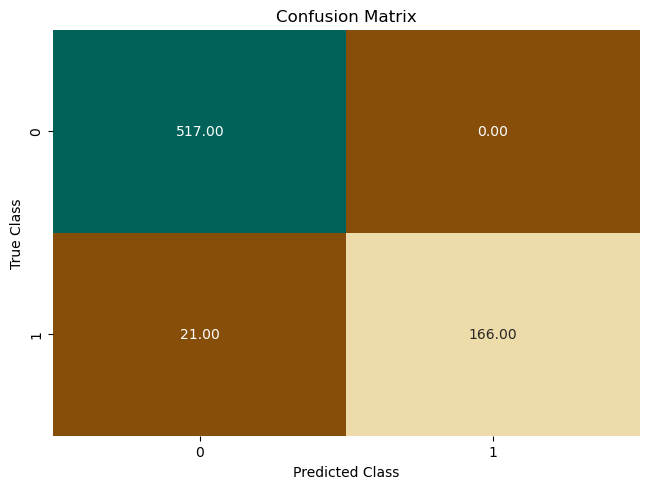

Sensitivity or TPR: 88.77005347593582%
Specificity or TNR: 100.0%
Precision: 100.0%
Negative Predictive Value: 96.09665427509294%
False Positive Rate: 0.0%
False Negative Rate: 11.229946524064172%
False Discovery Rate: 0.0%
Accuracy: 97.01704545454545%
Validation AUC 0.9438502673796791


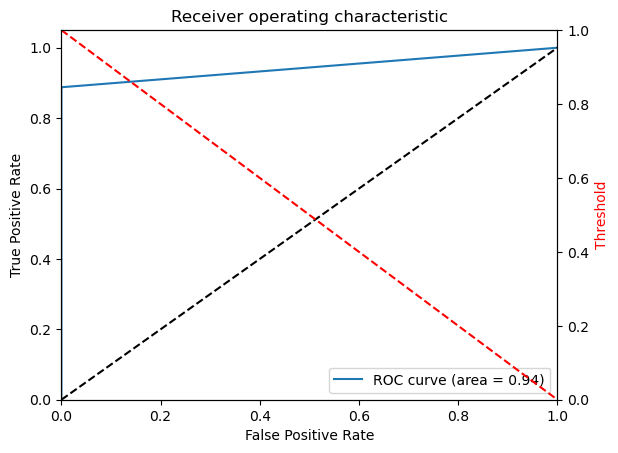

In [33]:
# Step 5: Evaluate model
print("\n===== Evaluating Best Model Performance =====")
plot_confusion_matrix(test_labels, predictions_binary)
plot_roc(test_labels, predictions_binary)

### Step 6: Model metrics

In [34]:
# Step 6: Model metrics
# Calculate F1 score
f1 = calculate_f1_score(test_labels, predictions_binary)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9405


### Step 7: Precision-Recall curve


Precision-Recall Curve:


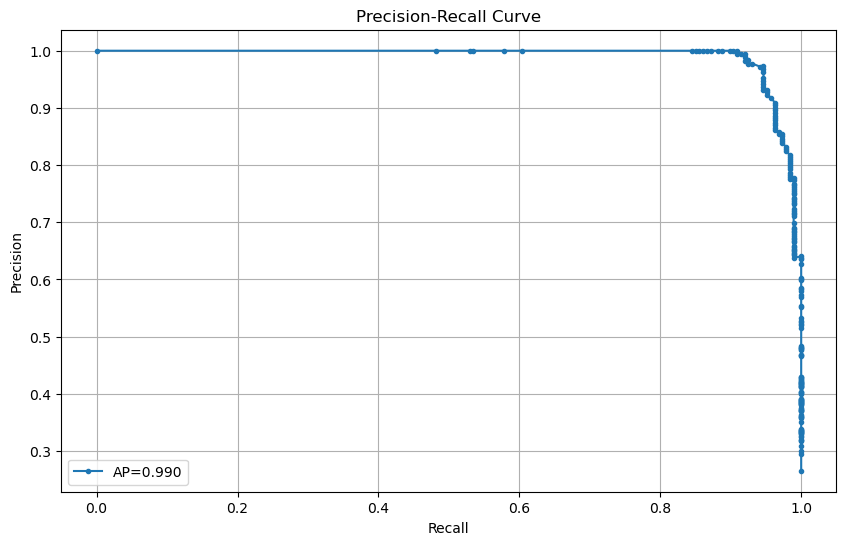

In [35]:
# Step 7: Precision-Recall curve
print("\nPrecision-Recall Curve:")
precision, recall, pr_thresholds = plot_precision_recall_curve(test_labels, predictions['Churn'])

# Section 4: Cleanup and Save Predictions

To add testing steps for Round 2

### Step 1: Save predictions to local file and S3

In [36]:
# First, create a DataFrame with test data and predictions
results_df = test.copy()
results_df['prediction'] = predictions['Churn']
results_df['prediction_binary'] = predictions_binary

In [37]:
# Save to local CSV
local_predictions_file = 'predictions_results.csv'
results_df.to_csv(local_predictions_file, index=False)
print(f"Predictions saved to local file: {local_predictions_file}")

Predictions saved to local file: predictions_results.csv


In [38]:
# Save to S3
s3_predictions_key = os.path.join(prefix, 'results/predictions_results.csv')
csv_buffer = io.StringIO()
results_df.to_csv(csv_buffer, index=False)
s3_resource.Bucket(bucket).Object(s3_predictions_key).put(Body=csv_buffer.getvalue())
print(f"Predictions saved to S3: s3://{bucket}/{s3_predictions_key}")

Predictions saved to S3: s3://telco-churn-cp/folders/results/predictions_results.csv


### Step 2: Lift and gain charts


Lift and Gain Charts:


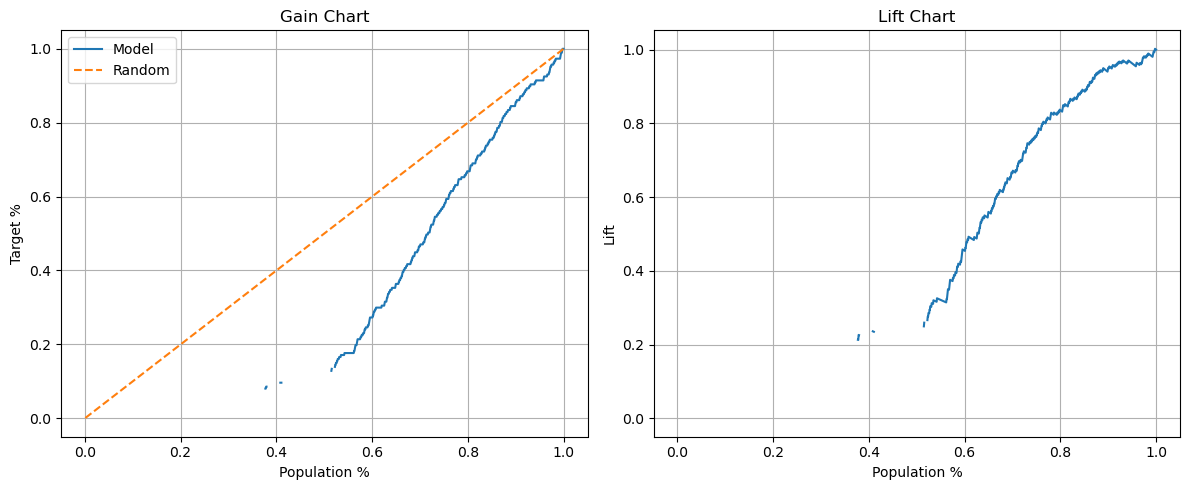

In [39]:
# Step 2: Lift and gain charts
print("\nLift and Gain Charts:")
plot_lift_gain_chart(test_labels, predictions['Churn'])

### Step 3: Get best params from tuning job to use locally

In [40]:
# Step 3: Get best params from tuning job to use locally
best_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error@.50', # to change when optimal threshold is obtained
    'alpha': float(df_tuning_job_analytics.iloc[0]['alpha']),
    'min_child_weight': float(df_tuning_job_analytics.iloc[0]['min_child_weight']),
    'subsample': float(df_tuning_job_analytics.iloc[0]['subsample']),
    'eta': float(df_tuning_job_analytics.iloc[0]['eta']), 
    'num_round': int(df_tuning_job_analytics.iloc[0]['num_round'])
}

### Step 4: Save best parameters for future use

In [41]:
# Step 4: Save best parameters for future use
import json
# Save locally
with open('best_params.json', 'w') as f:
    json.dump(best_params, f, indent=4)
print("Best parameters saved to best_params.json")


Best parameters saved to best_params.json


In [42]:
# Save to S3
params_string = json.dumps(best_params, indent=4)
s3_resource.Bucket(bucket).Object(os.path.join(prefix, 'model/best_params.json')).put(Body=params_string)
print(f"Best parameters saved to s3://{bucket}/{prefix}/model/best_params.json")


Best parameters saved to s3://telco-churn-cp/folders/model/best_params.json


### Step 5: Feature importance analysis

In [45]:
#!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 126.0 MB/s eta 0:00:00


In [43]:
# Step 5: Feature importance analysis
print("\nFeature Importance Analysis:")
X_test = test.drop('Churn', axis=1)
y_test = test['Churn']



Feature Importance Analysis:


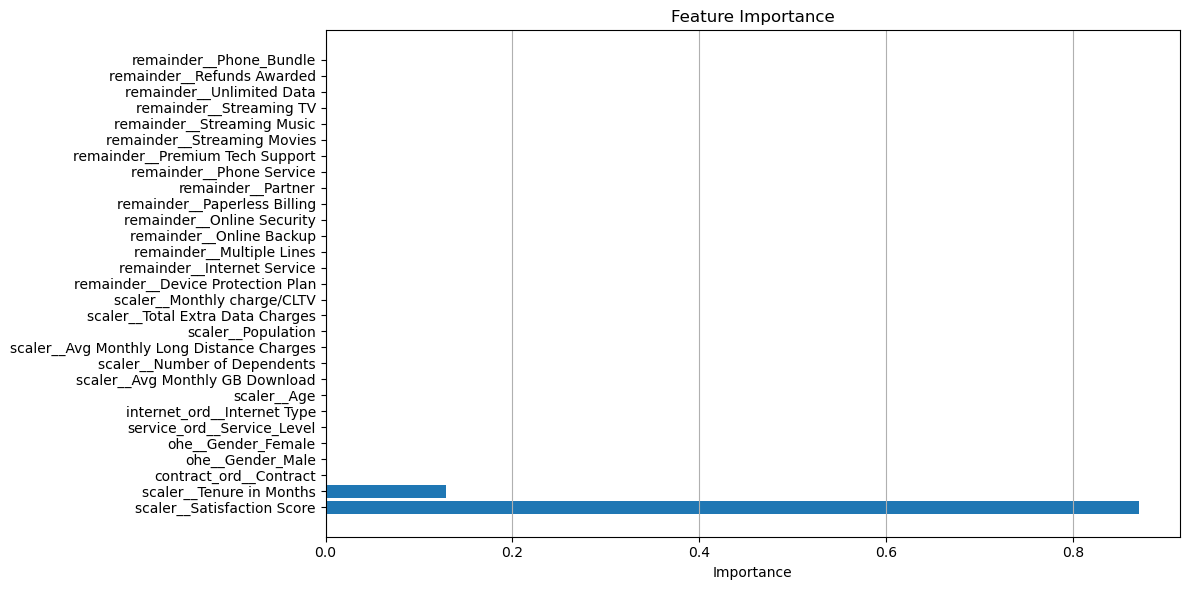

Top 5 important features:
                       Feature  Importance
10  scaler__Satisfaction Score    0.871014
11    scaler__Tenure in Months    0.128986
2       contract_ord__Contract    0.000000
1             ohe__Gender_Male    0.000000
0           ohe__Gender_Female    0.000000


In [46]:
feat_importance = plot_feature_importance(X_test, y_test, best_params)
print("Top 5 important features:")
print(feat_importance.head(5))

### Step 6: Partial dependence plots for top features


Partial Dependence Plots for Top Features:


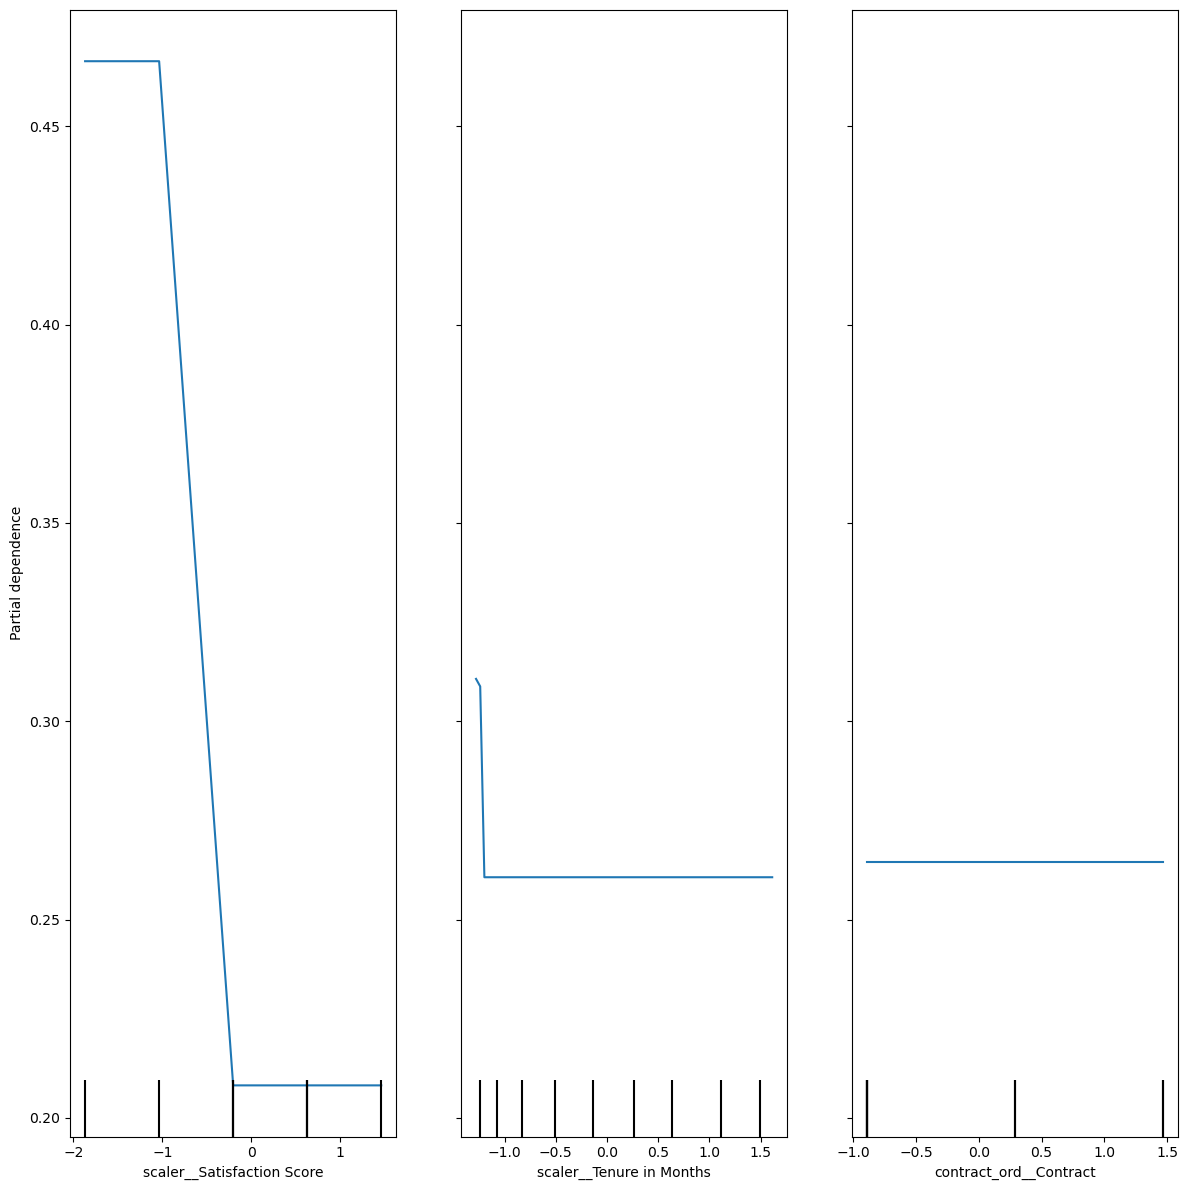

In [52]:
# Step 6: Partial dependence plots for top features
print("\nPartial Dependence Plots for Top Features:")
top_features = feat_importance['Feature'].head(3).tolist()
plot_partial_dependence(X_test, y_test, best_params, features=top_features)

### Step 7: Delete endpoint (only once)

In [53]:
# Step 7: Delete endpoint only once
print("\n===== Cleanup: Delete Endpoint =====")
try:
    predictor.delete_endpoint(delete_endpoint_config=True)
    print("Endpoint deleted successfully")
except Exception as e:
    print(f"Error deleting endpoint: {e}")
    endpoints = boto3.client('sagemaker').list_endpoints()
    print("Active endpoints that may need manual cleanup:")
    for endpoint in endpoints['Endpoints']:
        print(f"  - {endpoint['EndpointName']}")


===== Cleanup: Delete Endpoint =====


[03/31/25 23:35:34] INFO     Deleting endpoint configuration with name:                             ]8;id=43132;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=562078;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4913\4913]8;;\
                             sagemaker-xgboost-2025-03-31-23-21-11-573                                             

                    INFO     Deleting endpoint with name: sagemaker-xgboost-2025-03-31-23-21-11-573 ]8;id=229284;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=772545;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4903\4903]8;;\

Endpoint deleted successfully


### Step 8: Final cleanup check

In [54]:
# Step 8: Final cleanup check
try:
    endpoints = boto3.client('sagemaker').list_endpoints()
    if endpoints['Endpoints']:
        print("WARNING: You still have active endpoints that may incur charges:")
        for endpoint in endpoints['Endpoints']:
            print(f"  - {endpoint['EndpointName']}")
    else:
        print("No active endpoints found. Good job cleaning up!")
except Exception as e:
    print(f"Could not check for active endpoints: {e}")
    
print("Script execution completed")

No active endpoints found. Good job cleaning up!
Script execution completed
